## 8.1 自编码网络的介绍及其应用

In [1]:
# 自编码网络是非监督学习领域的一种，可以自动从无标注的数据中学习特征
# 是一种以重构输入信号为目的的神经网络，它可以给出比原数据更好的特征描述
# 在深度学习中常用自编码网络生成的特征来取代原始数据，以得到更好的效果

# 8.2 最简单的自编码网络

In [2]:
# 自编码网络(Auto-Encoder, AE)网络最基本的模型可以视为三层的神经网络—输入层，隐藏层和输出层
# 输入层的样本也会充当输出层的标签角色
# 自编码神经网络是一种尽可能复现输入信号的神经网络

# 从输入到中间状态的过程称为编码，从中间状态到输出的过程称为解码
# 自编码器要求输出尽可能接近于输入，并且其隐藏层必须满足一定的稀疏性
# 可以通过将隐藏层中的后一层神经元个数比前一层少的方式来实现稀疏效果

# 相当于隐藏层对输入进行了压缩，并在输出层进行了解压
# 整个过程肯定会丢失信息，但训练过程能够使丢失信息尽量减少，最大化保留其主要特征

## 8.3 自编码网络的代码实现

### 8.3.1 提取图片特征，并利用特征还原图片

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch:1 cost=0.209260091
Epoch:6 cost=0.143910289
Epoch:11 cost=0.129593134
Epoch:16 cost=0.116273269
Finished!
Accuracy:Tensor("Mean_7:0", shape=(), dtype=float32)


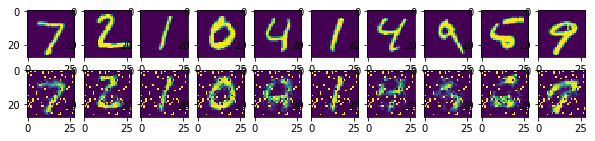

In [17]:
# 通过构建一个两层降维的自编码网络，将MNIST数据集的特征提取出来，并通过这些特征再重建一个MNIST数据集

# 引入头文件，并加载数据集
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

# 定义网路模型
# 输入MNIST数据集的图片，将其像素点组成的数据(28X28=784)从784降维到256，然后再降到128
# 然后以相反的方式从128，256，到784进行还原


n_input = 784 # MNIST数据集中图片的维度
n_hidden_1 = 256 # 第一层256个节点
n_hidden_2 = 128 # 第二层128个节点

# 占位符
x = tf.placeholder('float', [None, n_input]) # 输入
y = x # 输出

# 学习参数
weights = {
    'encoder_h1':tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2':tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1':tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2':tf.Variable(tf.random_normal([n_hidden_1, n_input]))}

biases = {
    'encoder_b1':tf.Variable(tf.zeros([n_hidden_1])),
    'encoder_b2':tf.Variable(tf.zeros([n_hidden_2])),
    'decoder_b1':tf.Variable(tf.zeros([n_hidden_1])),
    'decoder_b2':tf.Variable(tf.zeros([n_input]))}

# 编码
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2
# 解码
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2
    
#  输出的节点
encoder_out = encoder(x)
pred = decoder(encoder_out)

#  cost为y与pred的平方差
learning_rate = 0.01
cost = tf.reduce_mean(tf.pow(y-pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# 开始训练
# 训练参数
training_epochs = 20 # 一共迭代20次
batch_size = 256 # 一次处理256个样本
display_step = 5 # 每迭代5次输出一次信息

# 启动会话
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(mnist.train.num_examples/batch_size)
    # 开始训练
    for epoch in range(training_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size) # 取数据
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs})
            # 训练模型
        if epoch % display_step == 0: # 显示日志信息
            print('Epoch:{}'.format(epoch+1), 'cost={:.9f}'.format(c))
    print('Finished!')

# 测试模型

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
# 计算准确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    print('Accuracy:{}'.format(accuracy))

# 双比输入和输出
    show_num = 10
    reconstruction = sess.run(pred, feed_dict={x:mnist.test.images[: show_num]})
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range (show_num):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28, 28)))
        a[1][i].imshow(np.reshape(reconstruction[i], (28, 28)))
    plt.draw()

### 8.3.2 线性解码器

In [18]:
# 使用sigmoid函数作为激活函数时，输出范围是[0, 1],相当于对提取的特征节点进行范围压缩
# 由多个带有S型激活函数的隐含层以及一个线性输出层构成的编码器，称为线性编码器

### 8.3.3 提取图片的二维特征，并利用二位特征还原图片

In [23]:
# 在自编码网络中使用线性解码器对MNIST数据特征进行再压缩，并将其映射到直角坐标系上
# 使用4层逐渐将784维度分别压缩成256，64，16，2这4个特征向量
# 然后以直角坐标系的形式将数据点显示出来，这样可以直观地看到自编码器对同一类图片的聚类效果

# 引入头文件，定义学习参数变量
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 导入MNIST数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

n_input=784
# 隐藏层设置
n_hidden_1=256
n_hidden_2=64
n_hidden_3=16
n_hidden_4=2

# 定义输入占位符
x = tf.placeholder('float', shape=[None, n_input])
y=x

# 定义训练参数
weights={
    'encoder_h1':tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2':tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3':tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'encoder_h4':tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
    
    'decoder_h1':tf.Variable(tf.random_normal([n_hidden_4, n_hidden_3])),
    'decoder_h2':tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h3':tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h4':tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}

biases={
    'encoder_b1':tf.Variable(tf.zeros([n_hidden_1])),
    'encoder_b2':tf.Variable(tf.zeros([n_hidden_2])),
    'encoder_b3':tf.Variable(tf.zeros([n_hidden_3])),
    'encoder_b4':tf.Variable(tf.zeros([n_hidden_4])),
    
    'decoder_b1':tf.Variable(tf.zeros([n_hidden_3])),
    'decoder_b2':tf.Variable(tf.zeros([n_hidden_2])),
    'decoder_b3':tf.Variable(tf.zeros([n_hidden_1])),
    'decoder_b4':tf.Variable(tf.zeros([n_input])),
}

# 定义网络模型
# 这里使用了线性解码器，在编码的最后一层没有进行sigmoid变换
# 这是因为生产的二维数据的数据特征已经变得十分重要，所以我们希望让它透传到解码器中
# 少一些变换可以最大化保存原有的主要特征
def encoder(x):
    layer1=tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer2=tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['encoder_h2']), biases['encoder_b2']))
    layer3=tf.nn.sigmoid(tf.add(tf.matmul(layer2, weights['encoder_h3']), biases['encoder_b3']))
    # encoder的最后一层没有进行sigmoid变换
    layer4=tf.add(tf.matmul(layer3, weights['encoder_h4']), biases['encoder_b4']) 
    return layer4
def decoder(x):
    layer1=tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer2=tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['decoder_h2']), biases['decoder_b2']))
    layer3=tf.nn.sigmoid(tf.add(tf.matmul(layer2, weights['decoder_h3']), biases['decoder_b3']))
    layer4=tf.nn.sigmoid(tf.add(tf.matmul(layer3, weights['encoder_h4']), biases['encoder_b4']))
    return layer4

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
# 构建模型
encoder_op = encoder(x)
y_pred = decoder(encoder_op)
 
learning_rate = 